# Generative Adversarial Network(GAN) 
![jupyter](https://miro.medium.com/max/1400/1*t78gwhhw-hn1CgXc1K89wA.png)

GAN is an unsupervised deep learning algorithm where we have a Generator pitted against an adversarial network called Discriminator.

Generator generates counterfeit currency. Discriminators are a team of cops trying to detect the counterfeit currency. Counterfeiters and cops both are trying to beat each other at their game.

Both Generator and Discriminator will be multi-layer perceptrons(MLP)

Generator’s objective will be to generate data that is very similar to the training data. Data generated from Generator should be indistinguishable from the real data.

Discriminator takes two sets of input, one input comes from the training dataset(real data) and the other input is the dataset generated by Generator.


Since self.discriminator.trainable = False is set after the discriminator is compiled, it will not affect the training of the discriminator. However since it is set before the combined model is compiled the discriminator layers will be frozen when the combined model is trained.


In [11]:
## 1. Import the required libraries/modules/functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras import optimizers 

In [12]:
## 2. Load the data set
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    
    # convert shape of x_train from (60000, 28, 28) to (60000, 784) 
    # 784 columns per row
    x_train = x_train.reshape(60000, 784)
    return (x_train, y_train, x_test, y_test)

(X_train, y_train,X_test, y_test)=load_data()
print(X_train.shape)

(60000, 784)


Both Generator and Discriminator will be multi-layer perceptrons (MLP). However, you can also design any models for either the Generator and the Discriminator. Here is the structure of the Generator used in this example. 

Input: random varialbes, i.e., a 100-D random variable.
Output: an image represented by a 784-D vector

![jupyter](https://miro.medium.com/max/1400/1*Sqhji7Zz4IK2HDgCOabhXQ.png)

In [27]:
## 3. Design the Generator

def create_generator():
    generator=Sequential()
    generator.add(Dense(units=256,input_dim=100))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=512))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=1024))
    generator.add(LeakyReLU(0.2))
    
    generator.add(Dense(units=784, activation='tanh')) #28*28
    
    generator.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4))
    return generator
g=create_generator()
g.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_39 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 784)             

Discriminator which is also multi-layer perceptrons (MLP). However, you can also design any models for  the Discriminator. 
Input: two groups of imageins, i.e., a group of  real data which is of the size 784 and a group of fake data from  the Generator.

In [28]:
## 4. Design the Discriminator

def create_discriminator():
    discriminator=Sequential()
    discriminator.add(Dense(units=1024,input_dim=784))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    
    discriminator.add(Dense(units=512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))
       
    discriminator.add(Dense(units=256))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4))
    return discriminator
d =create_discriminator()
d.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_53 (Dense)             (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_40 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_54 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_41 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)             

We now create the GAN where we combine the Generator and the Discriminator. When we train the Generator we will freeze the Discriminator.
Since self.discriminator.trainable = False is set after the discriminator is compiled, it will not affect the training of the discriminator. However since it is set before the combined model is compiled the discriminator layers will be frozen when the combined model is trained.

We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

In [29]:
## 5. Combining the Generator with the Discriminator to obtain the GAN model

def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(100,))
    x = generator(gan_input)
    gan_output= discriminator(x)
    gan= Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan
gan = create_gan(d,g)
gan.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_13 (Sequential)   (None, 784)               1486352   
_________________________________________________________________
sequential_14 (Sequential)   (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


Function plot_generated_images to plot the generated images. This way we can see how the images are generated. We save the generated images to file that we can view later

In [30]:
## Optional step   plot the generated images 

def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    ###############################
    plt.savefig('./GAN_pictures/gan_generated_image %d.png' %epoch)

In [31]:
noise= np.random.normal(0,1, [128, 100])
noise

array([[ 0.57459722, -1.69953859,  1.76096659, ...,  0.35451209,
        -0.37862732,  0.7922229 ],
       [-0.80277395,  1.97155934,  0.15000475, ..., -2.14775368,
        -0.30174802, -0.41984153],
       [-0.71885003,  1.64273006,  0.23691803, ...,  0.05396392,
        -0.80650293,  1.65208659],
       ...,
       [-0.30925719, -0.30343386,  1.25824036, ...,  0.03844078,
         0.71620335, -1.78921378],
       [ 0.87694605, -0.7965713 , -0.45229056, ..., -1.010308  ,
        -2.38030583, -0.31873297],
       [-0.39365358, -0.43960455,  0.25753533, ..., -0.48545578,
        -0.29589858, -0.93551719]])

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1


  2%|▏         | 2/128 [00:00<00:12, 10.41it/s]

Epoch 2


  1%|          | 1/128 [00:00<00:13,  9.31it/s]

Epoch 3


  2%|▏         | 2/128 [00:00<00:11, 10.95it/s]

Epoch 4


  1%|          | 1/128 [00:00<00:12,  9.96it/s]

Epoch 5


  1%|          | 1/128 [00:00<00:13,  9.52it/s]

Epoch 6


  2%|▏         | 2/128 [00:00<00:11, 10.95it/s]

Epoch 7


  2%|▏         | 2/128 [00:00<00:11, 11.08it/s]

Epoch 8


  1%|          | 1/128 [00:00<00:13,  9.56it/s]

Epoch 9


  2%|▏         | 2/128 [00:00<00:11, 11.19it/s]

Epoch 10


  2%|▏         | 2/128 [00:00<00:11, 11.38it/s]

Epoch 11


  2%|▏         | 2/128 [00:00<00:11, 10.74it/s]

Epoch 12


  2%|▏         | 2/128 [00:00<00:11, 11.14it/s]

Epoch 13


  2%|▏         | 2/128 [00:00<00:11, 11.33it/s]

Epoch 14


  2%|▏         | 2/128 [00:00<00:11, 11.12it/s]

Epoch 15


  2%|▏         | 2/128 [00:00<00:11, 11.35it/s]

Epoch 16


  2%|▏         | 2/128 [00:00<00:11, 11.37it/s]

Epoch 17


  2%|▏         | 2/128 [00:00<00:11, 11.26it/s]

Epoch 18


  2%|▏         | 2/128 [00:00<00:11, 11.11it/s]

Epoch 19


  2%|▏         | 2/128 [00:00<00:11, 11.35it/s]

Epoch 20


  2%|▏         | 2/128 [00:00<00:10, 11.63it/s]

Epoch 21


  2%|▏         | 2/128 [00:00<00:10, 11.59it/s]

Epoch 22


  2%|▏         | 2/128 [00:00<00:10, 11.54it/s]

Epoch 23


  2%|▏         | 2/128 [00:00<00:11, 10.90it/s]

Epoch 24


  2%|▏         | 2/128 [00:00<00:10, 11.46it/s]

Epoch 25


  2%|▏         | 2/128 [00:00<00:11, 11.06it/s]

Epoch 26


  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 27


  2%|▏         | 2/128 [00:00<00:11, 10.89it/s]

Epoch 28


  2%|▏         | 2/128 [00:00<00:11, 10.99it/s]

Epoch 29


  2%|▏         | 2/128 [00:00<00:10, 11.62it/s]

Epoch 30


  2%|▏         | 2/128 [00:00<00:11, 11.28it/s]

Epoch 31


  2%|▏         | 2/128 [00:00<00:11, 11.19it/s]

Epoch 32


  2%|▏         | 2/128 [00:00<00:10, 11.62it/s]

Epoch 33


  2%|▏         | 2/128 [00:00<00:11, 11.44it/s]

Epoch 34


  2%|▏         | 2/128 [00:00<00:11, 10.80it/s]

Epoch 35


  2%|▏         | 2/128 [00:00<00:11, 10.81it/s]

Epoch 36


  2%|▏         | 2/128 [00:00<00:11, 11.40it/s]

Epoch 37


  2%|▏         | 2/128 [00:00<00:11, 10.77it/s]

Epoch 38


  2%|▏         | 2/128 [00:00<00:11, 10.94it/s]

Epoch 39


  2%|▏         | 2/128 [00:00<00:11, 11.24it/s]

Epoch 40


  2%|▏         | 2/128 [00:00<00:10, 12.37it/s]

Epoch 41


  1%|          | 1/128 [00:00<00:12,  9.92it/s]

Epoch 42


  1%|          | 1/128 [00:00<00:12,  9.87it/s]

Epoch 43


  2%|▏         | 2/128 [00:00<00:10, 11.51it/s]

Epoch 44


  2%|▏         | 2/128 [00:00<00:11, 11.19it/s]

Epoch 45


  2%|▏         | 2/128 [00:00<00:11, 10.88it/s]

Epoch 46


  2%|▏         | 2/128 [00:00<00:11, 10.87it/s]

Epoch 47


  2%|▏         | 2/128 [00:00<00:11, 10.74it/s]

Epoch 48


  1%|          | 1/128 [00:00<00:12,  9.85it/s]

Epoch 49


  2%|▏         | 2/128 [00:00<00:11, 10.69it/s]

Epoch 50


  2%|▏         | 2/128 [00:00<00:10, 11.46it/s]

Epoch 51


  2%|▏         | 2/128 [00:00<00:11, 10.95it/s]

Epoch 52


  2%|▏         | 2/128 [00:00<00:11, 10.86it/s]

Epoch 53


  2%|▏         | 2/128 [00:00<00:11, 11.00it/s]

Epoch 54


  2%|▏         | 2/128 [00:00<00:10, 11.73it/s]

Epoch 55


  2%|▏         | 2/128 [00:00<00:11, 10.79it/s]

Epoch 56


  2%|▏         | 2/128 [00:00<00:10, 11.68it/s]

Epoch 57


  2%|▏         | 2/128 [00:00<00:11, 11.35it/s]

Epoch 58


  2%|▏         | 2/128 [00:00<00:11, 11.21it/s]

Epoch 59


  2%|▏         | 2/128 [00:00<00:11, 11.27it/s]

Epoch 60


  2%|▏         | 2/128 [00:00<00:10, 12.12it/s]

Epoch 61


  2%|▏         | 2/128 [00:00<00:11, 10.90it/s]

Epoch 62


  2%|▏         | 2/128 [00:00<00:11, 10.98it/s]

Epoch 63


  2%|▏         | 2/128 [00:00<00:10, 11.50it/s]

Epoch 64


  2%|▏         | 2/128 [00:00<00:10, 11.52it/s]

Epoch 65


  2%|▏         | 2/128 [00:00<00:11, 11.23it/s]

Epoch 66


  2%|▏         | 2/128 [00:00<00:12,  9.85it/s]

Epoch 67


  2%|▏         | 2/128 [00:00<00:11, 10.90it/s]

Epoch 68


  2%|▏         | 2/128 [00:00<00:12, 10.44it/s]

Epoch 69


  2%|▏         | 2/128 [00:00<00:10, 11.75it/s]

Epoch 70


  2%|▏         | 2/128 [00:00<00:11, 10.61it/s]

Epoch 71


  2%|▏         | 2/128 [00:00<00:11, 10.91it/s]

Epoch 72


  2%|▏         | 2/128 [00:00<00:11, 10.85it/s]

Epoch 73


  2%|▏         | 2/128 [00:00<00:11, 11.02it/s]

Epoch 74


  2%|▏         | 2/128 [00:00<00:11, 11.27it/s]

Epoch 75


  2%|▏         | 2/128 [00:00<00:11, 10.57it/s]

Epoch 76


  2%|▏         | 2/128 [00:00<00:11, 11.20it/s]

Epoch 77


  2%|▏         | 2/128 [00:00<00:11, 11.06it/s]

Epoch 78


  2%|▏         | 2/128 [00:00<00:10, 11.59it/s]

Epoch 79


  2%|▏         | 2/128 [00:00<00:11, 11.44it/s]

Epoch 80


  2%|▏         | 2/128 [00:00<00:10, 12.05it/s]

Epoch 81


  1%|          | 1/128 [00:00<00:13,  9.18it/s]

Epoch 82


  2%|▏         | 2/128 [00:00<00:11, 10.63it/s]

Epoch 83


  2%|▏         | 2/128 [00:00<00:10, 11.57it/s]

Epoch 84


  2%|▏         | 2/128 [00:00<00:11, 11.23it/s]

Epoch 85


  2%|▏         | 2/128 [00:00<00:11, 11.23it/s]

Epoch 86


  2%|▏         | 2/128 [00:00<00:10, 11.54it/s]

Epoch 87


  2%|▏         | 2/128 [00:00<00:11, 11.11it/s]

Epoch 88


  2%|▏         | 2/128 [00:00<00:11, 10.80it/s]

Epoch 89


  2%|▏         | 2/128 [00:00<00:10, 11.89it/s]

Epoch 90


  2%|▏         | 2/128 [00:00<00:11, 11.36it/s]

Epoch 91


  2%|▏         | 2/128 [00:00<00:10, 12.08it/s]

Epoch 92


  2%|▏         | 2/128 [00:00<00:10, 11.88it/s]

Epoch 93


  2%|▏         | 2/128 [00:00<00:11, 11.22it/s]

Epoch 94


  2%|▏         | 2/128 [00:00<00:10, 12.08it/s]

Epoch 95


  2%|▏         | 2/128 [00:00<00:11, 11.30it/s]

Epoch 96


  2%|▏         | 2/128 [00:00<00:10, 11.84it/s]

Epoch 97


  2%|▏         | 2/128 [00:00<00:10, 11.54it/s]

Epoch 98


  2%|▏         | 2/128 [00:00<00:11, 11.32it/s]

Epoch 99


  2%|▏         | 2/128 [00:00<00:10, 12.18it/s]

Epoch 100


100%|██████████| 128/128 [00:10<00:00, 11.66it/s]


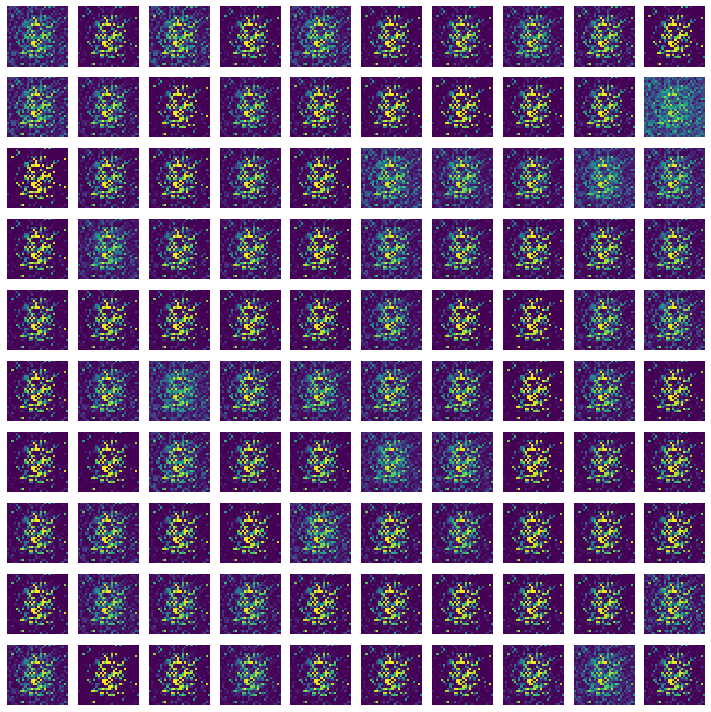

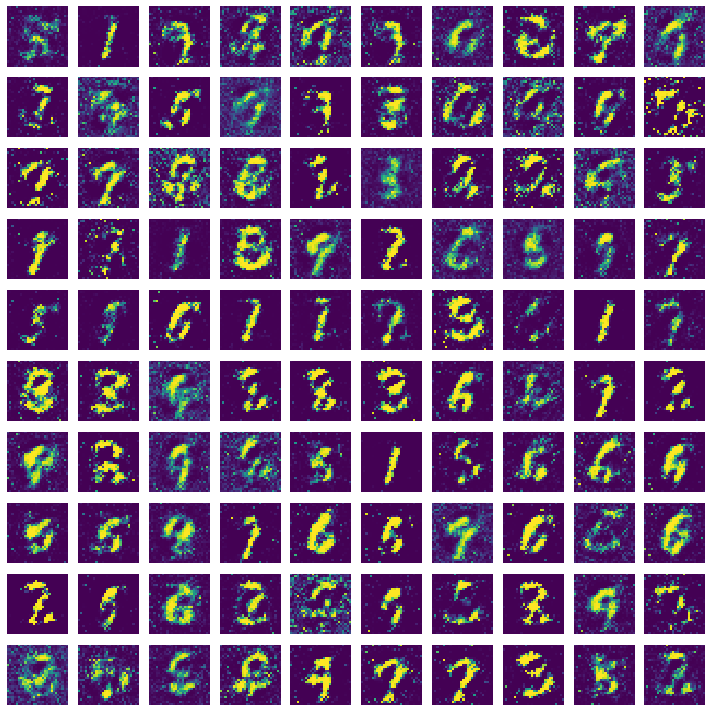

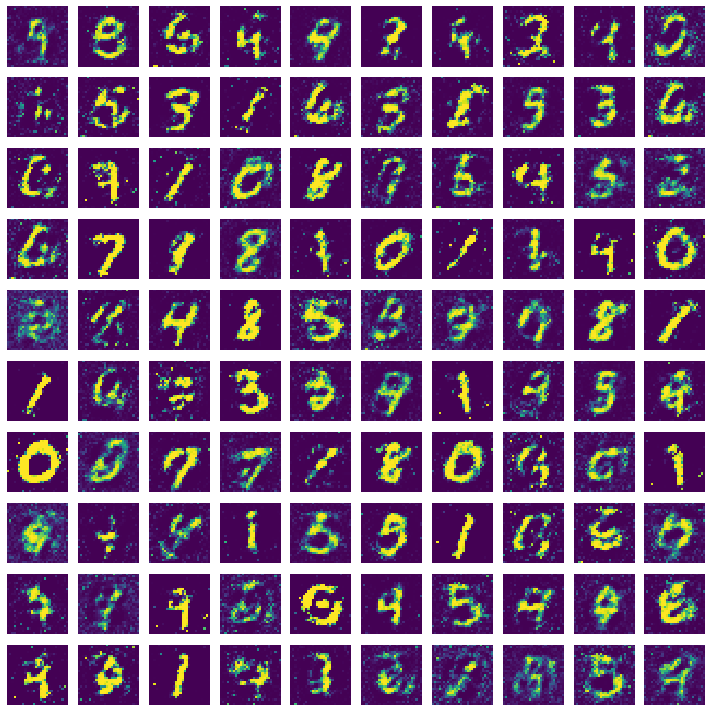

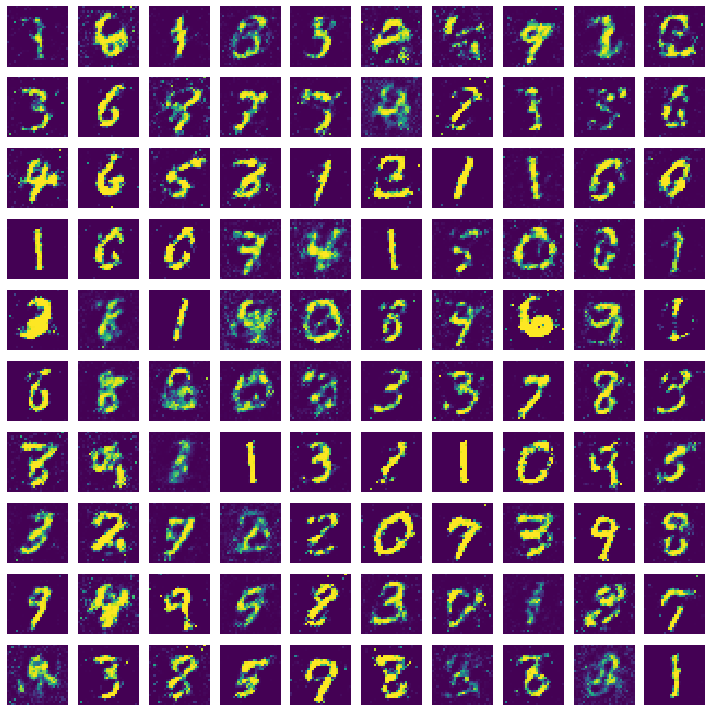

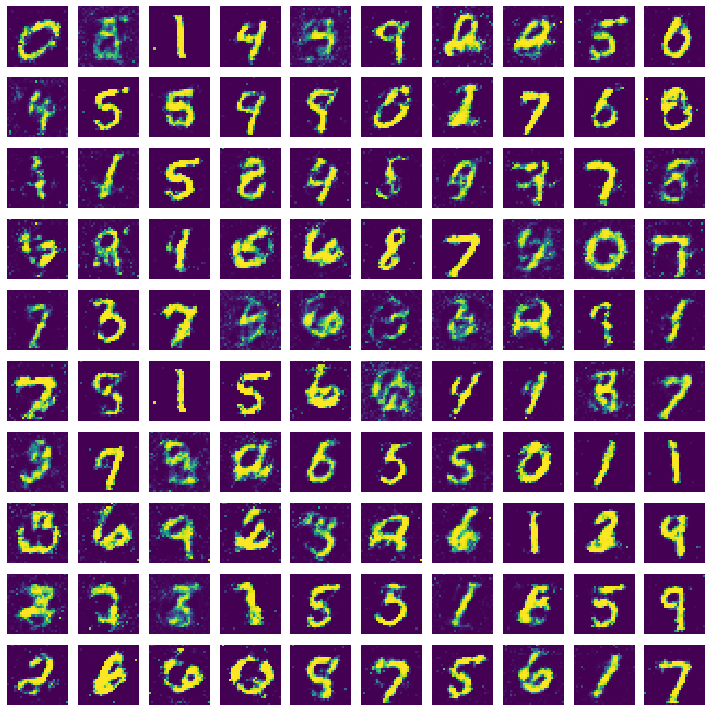

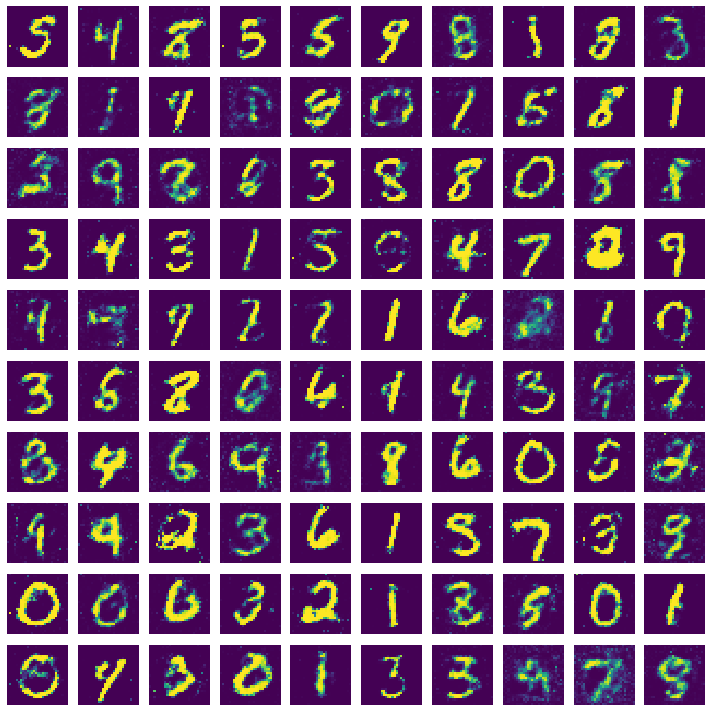

In [33]:
## 6. Training the designed model with the above functions

# noise= np.random.normal(0,1, [128, 100])

def training(epochs=1, batch_size=128):
    
    #Loading the data
    (X_train, y_train, X_test, y_test) = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator= create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
        #generate  random noise as an input  to  initialize the  generator
#             noise= np.random.normal(0,1, [batch_size, 100])
            noise= np.random.normal(0,1, [batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images 
            image_batch =X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of  real and fake data 
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y_dis=np.zeros(2*batch_size) #valid
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            discriminator.train_on_batch(X, y_dis) # 如果是 0 就 train discriminator
            
            #Tricking the noised input of the Generator as real data
            noise= np.random.normal(0,1, [batch_size, 100])
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False 
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)  # 如果是 1 就 train generator
            
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator)

# training(400,128)

training(100,128)

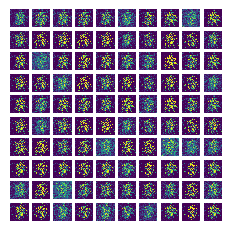

In [22]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import numpy as np
import scipy
from scipy import misc
from PIL import Image

lena = Image.open('./GAN_pictures/gan_generated_image 1.png') # 读取和代码处于同一目录下的 lena.png
# lena = Image.open('./lena.jpg') # 读取和代码处于同一目录下的 lena.png
plt.imshow(lena) 
plt.axis('off')
plt.show()


In [ ]:
https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3